<a href="https://colab.research.google.com/github/Manith-Ratnayake/Data-Enginnering/blob/main/Data_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Data Pre Proccessing**

In [19]:
# Google drive and google collab connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# In google collab pyspark is not pre installed
!pip install pyspark

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, median, stddev

In [23]:
# Creating a py spark session
spark = SparkSession.builder \
    .appName("HCHO Analysis") \
    .getOrCreate()

In [24]:
# Reading three files
col_mat_nuw_data = spark.read.csv("/content/drive/My Drive/Data Engineering/col_mat_nuw_output.csv", header=False)
kan_data = spark.read.csv("/content/drive/My Drive/Data Engineering/kan_output.csv", header=False)
mon_kur_jaf_data = spark.read.csv("/content/drive/My Drive/Data Engineering/mon_kur_jaf_output.csv", header=False)

# Combining all files into 1 file
all_data = col_mat_nuw_data.union(mon_kur_jaf_data).union(kan_data)

# Checking the current column names
print(all_data.columns)

# Changing column name to meaninful name
# Rename the columns to more meaningful names
all_data = all_data.withColumnRenamed('_c0', 'HCHO Reading') \
                   .withColumnRenamed('_c1', 'Location') \
                   .withColumnRenamed('_c2', 'Current Date') \
                   .withColumnRenamed('_c3', 'Next Date')

print(all_data.columns)

['_c0', '_c1', '_c2', '_c3']
['HCHO Reading', 'Location', 'Current Date', 'Next Date']


In [25]:
from pyspark.sql.functions import col, sum as pyspark_sum

# Define a list of column names
columns = all_data.columns

# Create a dictionary to store the count of missing values for each column
missing_value_counts = {}

# Loop through each column and count the missing values
for col_name in columns:
    missing_count = all_data.filter(col(col_name).isNull()).count()
    missing_value_counts[col_name] = missing_count

# Print the count of missing values for each column
print("Number of missing values in each column:")
for col_name, count in missing_value_counts.items():
    print(col_name, ": ", count)

Number of missing values in each column:
HCHO Reading :  4864
Location :  0
Current Date :  0
Next Date :  0


In [32]:
from pyspark.sql.functions import mean as pyspark_mean, when

# Impute missing values for numerical columns with the mean
numerical_columns = ['HCHO Reading']  # Assuming 'HCHO Reading' is the only numerical column
for col_name in numerical_columns:
    mean_value = all_data.select(pyspark_mean(col(col_name)).alias('mean')).collect()[0]['mean']
    all_data = all_data.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))

# Impute missing values for categorical columns with the most frequent category
categorical_columns = ['Location', 'Current Date', 'Next Date']  # Assuming these are categorical columns
for col_name in categorical_columns:
    most_frequent_value = all_data.groupBy(col_name).count().orderBy(col('count').desc()).first()[col_name]
    all_data = all_data.withColumn(col_name, when(col(col_name).isNull(), most_frequent_value).otherwise(col(col_name)))

# Recheck missing values after imputation
missing_value_counts_after_imputation = {}
for col_name in all_data.columns:
    missing_count = all_data.filter(col(col_name).isNull()).count()
    missing_value_counts_after_imputation[col_name] = missing_count

# Print the count of missing values for each column after imputation
print("Number of missing values in each column after imputation:")
for col_name, count in missing_value_counts_after_imputation.items():
    print(col_name, ": ", count)

Number of missing values in each column after imputation:
HCHO Reading :  0
Location :  0
Current Date :  0
Next Date :  0


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

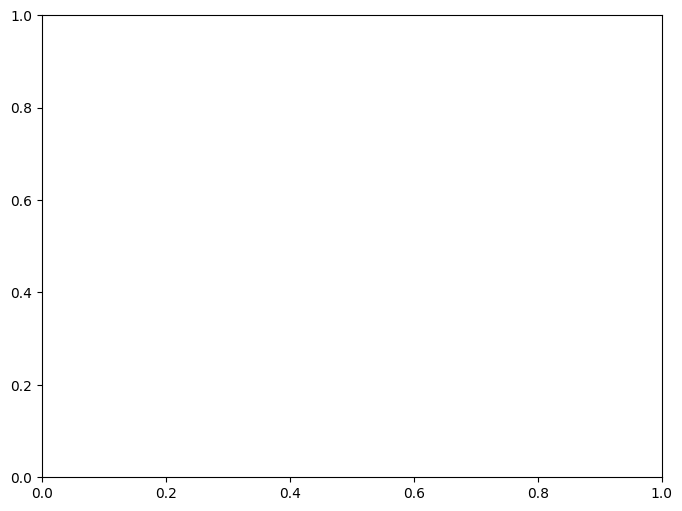

In [33]:
import matplotlib.pyplot as plt

# Select numerical columns for visualization
numerical_columns = ['HCHO Reading']  # Assuming 'HCHO Reading' is the only numerical column

# Create boxplots for each numerical column
for col_name in numerical_columns:
    # Convert column to Pandas DataFrame for visualization
    df = all_data.select(col_name).toPandas()

    # Create boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot(df[col_name], vert=False)
    plt.title(f'Boxplot of {col_name}')
    plt.xlabel(col_name)
    plt.show()


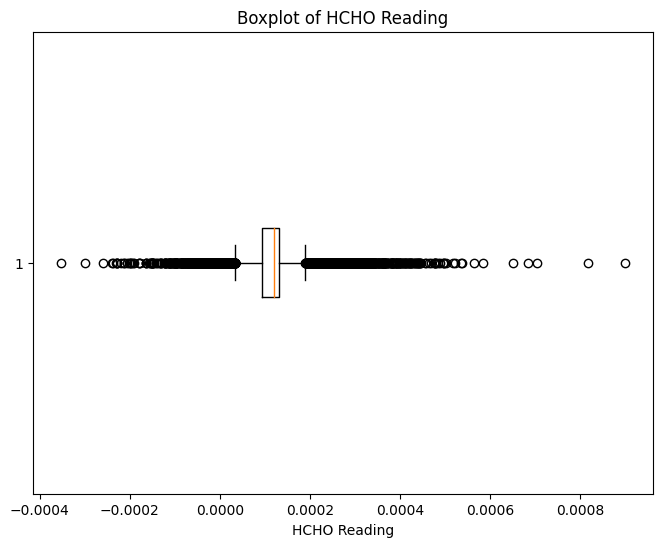

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Select numerical columns for visualization
numerical_columns = ['HCHO Reading']  # Assuming 'HCHO Reading' is the only numerical column

# Create boxplots for each numerical column
for col_name in numerical_columns:
    # Convert column to Pandas DataFrame for visualization
    df = all_data.select(col_name).toPandas()

    # Convert the column to the appropriate numeric type (optional, but might resolve the error)
    df[col_name] = pd.to_numeric(df[col_name])

    # Create boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot(df[col_name], vert=False)
    plt.title(f'Boxplot of {col_name}')
    plt.xlabel(col_name)
    plt.show()


In [35]:
from pyspark.sql.functions import mean, median, stddev

# Calculate descriptive statistics for each city
city_statistics = all_data.groupBy('Location') \
    .agg(mean('HCHO Reading').alias('Mean HCHO Reading'),
         median('HCHO Reading').alias('Median HCHO Reading'),
         stddev('HCHO Reading').alias('Stddev HCHO Reading'))

# Calculate descriptive statistics across the entire dataset
overall_statistics = all_data.agg(mean('HCHO Reading').alias('Overall Mean HCHO Reading'),
                                  median('HCHO Reading').alias('Overall Median HCHO Reading'),
                                  stddev('HCHO Reading').alias('Overall Stddev HCHO Reading'))

# Show descriptive statistics for each city
print("Descriptive statistics for each city:")
city_statistics.show()

# Show descriptive statistics across the entire dataset
print("Descriptive statistics across the entire dataset:")
overall_statistics.show()


Descriptive statistics for each city:
+-------------------+--------------------+--------------------+--------------------+
|           Location|   Mean HCHO Reading| Median HCHO Reading| Stddev HCHO Reading|
+-------------------+--------------------+--------------------+--------------------+
|   Deniyaya, Matara|1.044686072749091...|1.192778916513748...|7.246053723404124E-5|
|     Colombo Proper|1.480916996036323...|1.192778916513748...| 8.67733015675361E-5|
|Nuwara Eliya Proper|1.065550795445532...|1.192778916513748...|5.545511452384686E-5|
|  Kurunegala Proper|1.292407039248092...|1.192778916513748...|7.165767483552864E-5|
| Bibile, Monaragala|1.237086665854354...|1.192778916513748...|7.406584214357455E-5|
|      Jaffna Proper|1.109013636756122...|1.192778916513748...|7.028672595049762E-5|
|       Kandy Proper|1.119791209506632E-4|1.192778916513748...| 6.94968491286915E-5|
+-------------------+--------------------+--------------------+--------------------+

Descriptive statistics acr

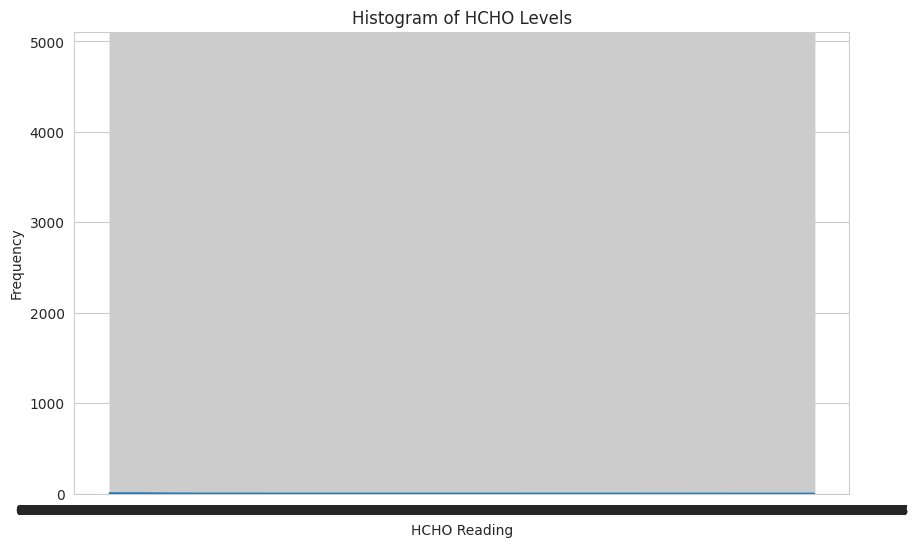

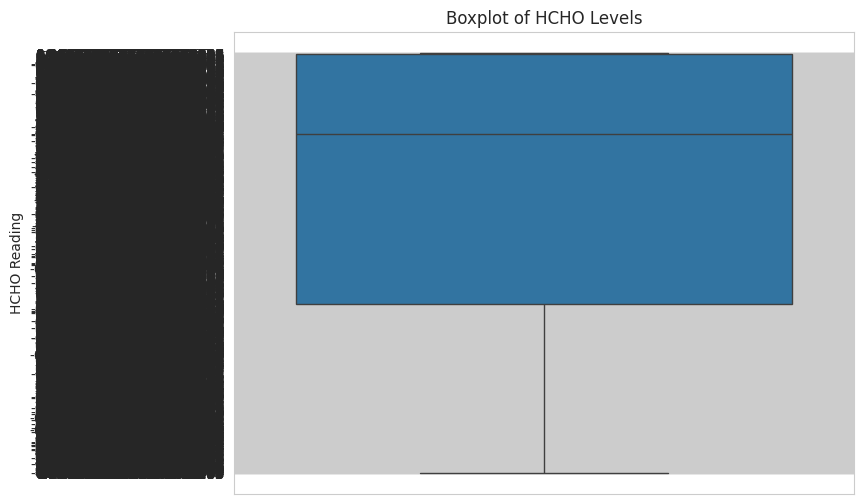

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
hcho_data_pd = all_data.select('HCHO Reading').toPandas()

# Set plot style
sns.set_style("whitegrid")

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=hcho_data_pd, x='HCHO Reading', bins=20, kde=True)
plt.title('Histogram of HCHO Levels')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=hcho_data_pd, y='HCHO Reading')
plt.title('Boxplot of HCHO Levels')
plt.ylabel('HCHO Reading')
plt.show()


In [38]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col



# Convert PySpark DataFrame to Pandas DataFrame
hcho_data_pd = all_data.select('Current Date', 'HCHO Reading') \
                       .orderBy('Current Date') \
                       .toPandas()

# Ensure 'Current Date' column is in datetime format
hcho_data_pd['Current Date'] = pd.to_datetime(hcho_data_pd['Current Date'])

# Set 'Current Date' as index
hcho_data_pd.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_data = hcho_data_pd.iloc[:int(0.8 * len(hcho_data_pd))]
test_data = hcho_data_pd.iloc[int(0.8 * len(hcho_data_pd)):]

# Define and fit ARIMA model
order = (5, 1, 0)  # Example order (p, d, q)
arima_model = ARIMA(train_data, order=order)
arima_result = arima_model.fit()

# Forecast future HCHO levels
forecast_steps = len(test_data)
forecast = arima_result.forecast(steps=forecast_steps)

# Evaluate the model (optional)
# You can use appropriate evaluation metrics such as RMSE, MAE, etc.

# Convert forecast result to PySpark DataFrame
forecast_df = spark.createDataFrame(zip(test_data.index, forecast), schema=['Current Date', 'Forecast HCHO'])

# Show forecast results
forecast_df.show()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
from pyspark.sql.functions import lit
from pyspark.ml.evaluation import RegressionEvaluator

# Convert forecast result to PySpark DataFrame
forecast_df = spark.createDataFrame(zip(test_data.index, forecast), schema=['Current Date', 'Forecast HCHO'])

# Join forecast and test data
evaluation_df = forecast_df.join(all_data.select('Current Date', 'HCHO Reading'), on='Current Date', how='inner') \
                           .withColumnRenamed('HCHO Reading', 'Actual HCHO')

# Calculate evaluation metrics
mse_evaluator = RegressionEvaluator(labelCol='Actual HCHO', predictionCol='Forecast HCHO', metricName='mse')
mse = mse_evaluator.evaluate(evaluation_df)

mae_evaluator = RegressionEvaluator(labelCol='Actual HCHO', predictionCol='Forecast HCHO', metricName='mae')
mae = mae_evaluator.evaluate(evaluation_df)

rmse = mse ** 0.5  # Calculate RMSE from MSE

# Print evaluation metrics
print("Evaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

In [26]:
# from pyspark.sql.functions import col, when, lag, lead
# from pyspark.sql.window import Window

# # Define a window specification partitioned by 'Location' and ordered by 'Current Date'
# window_spec = Window.partitionBy('Location').orderBy('Current Date')

# # Calculate lag and lead values
# lag_value = lag('HCHO Reading').over(window_spec)
# lead_value = lead('HCHO Reading').over(window_spec)

# # Fill missing values by taking the average of lag and lead values
# interpolated_value = (lag_value + lead_value) / 2

# # Fill missing values in 'HCHO Reading' column using interpolation
# interpolated_data = all_data.withColumn('HCHO Reading',
#                                         when(col('HCHO Reading').isNull(), interpolated_value)
#                                         .otherwise(col('HCHO Reading')))

# # Show the interpolated data
# print(interpolated_data.show())
# # Count the number of null values in each column
# null_counts = interpolated_data.select([col(c).isNull().alias(c) for c in interpolated_data.columns]).toPandas().sum()

# # Print the number of null values in each column
# print("Number of null values in each column:")
# print(null_counts)

In [27]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.regression import LinearRegression
# from pyspark.sql.functions import col

# # Select relevant columns for imputation
# selected_columns = ['HCHO Reading', 'Current Date', 'Next Date', 'Location']

# # Drop rows with missing values in any of the selected columns
# selected_data = interpolated_data.dropna(subset=selected_columns)

# # Convert 'Location' column to numerical using StringIndexer
# from pyspark.ml.feature import StringIndexer
# indexer = StringIndexer(inputCol="Location", outputCol="LocationIndex")
# indexed_data = indexer.fit(selected_data).transform(selected_data)

# # Create feature vector combining 'Current Date', 'Next Date', and 'LocationIndex'
# assembler = VectorAssembler(inputCols=["Current Date", "Next Date", "LocationIndex"], outputCol="features")
# assembled_data = assembler.transform(indexed_data)

# # Split data into training and testing sets
# (training_data, testing_data) = assembled_data.randomSplit([0.8, 0.2])

# # Train a linear regression model
# lr = LinearRegression(featuresCol='features', labelCol='HCHO Reading')
# lr_model = lr.fit(training_data)

# # Make predictions on testing data
# predictions = lr_model.transform(testing_data)

# # Replace missing values in 'HCHO Reading' column with predicted values
# imputed_data = interpolated_data.join(predictions.select('Current Date', 'Next Date', 'Location', 'prediction'),
#                                       on=['Current Date', 'Next Date', 'Location'], how='left')

# imputed_data = imputed_data.withColumn('HCHO Reading',
#                                        when(col('HCHO Reading').isNull(), col('prediction'))
#                                        .otherwise(col('HCHO Reading')))

# # Drop the 'prediction' column
# imputed_data = imputed_data.drop('prediction')

# # Show the imputed data
# imputed_data.show()


In [28]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.regression import LinearRegression
# from pyspark.sql.functions import col, datediff, lit

# # Select relevant columns for imputation
# selected_columns = ['HCHO Reading', 'Current Date', 'Next Date', 'Location']

# # Drop rows with missing values in any of the selected columns
# selected_data = interpolated_data.dropna(subset=selected_columns)

# # Convert date columns to numerical values representing days since a reference date
# reference_date = selected_data.selectExpr("min(`Current Date`)")
# reference_date_value = reference_date.collect()[0][0]

# selected_data = selected_data.withColumn("Days Since Reference", datediff(col("Current Date"), lit(reference_date_value)))

# # Convert 'Location' column to numerical using StringIndexer
# from pyspark.ml.feature import StringIndexer
# indexer = StringIndexer(inputCol="Location", outputCol="LocationIndex")
# indexed_data = indexer.fit(selected_data).transform(selected_data)

# # Create feature vector combining 'Days Since Reference', 'Next Date', and 'LocationIndex'
# assembler = VectorAssembler(inputCols=["Days Since Reference", "Next Date", "LocationIndex"], outputCol="features")
# assembled_data = assembler.transform(indexed_data)

# # Split data into training and testing sets
# (training_data, testing_data) = assembled_data.randomSplit([0.8, 0.2])

# # Train a linear regression model
# lr = LinearRegression(featuresCol='features', labelCol='HCHO Reading')
# lr_model = lr.fit(training_data)

# # Make predictions on testing data
# predictions = lr_model.transform(testing_data)

# # Replace missing values in 'HCHO Reading' column with predicted values
# imputed_data = interpolated_data.join(predictions.select('Current Date', 'Next Date', 'Location', 'prediction'),
#                                       on=['Current Date', 'Next Date', 'Location'], how='left')

# imputed_data = imputed_data.withColumn('HCHO Reading',
#                                        when(col('HCHO Reading').isNull(), col('prediction'))
#                                        .otherwise(col('HCHO Reading')))

# # Drop the 'prediction' column
# imputed_data = imputed_data.drop('prediction')

# # Show the imputed data
# imputed_data.show()


In [29]:
# from pyspark.sql.functions import col, datediff, to_date

# # Convert 'Next Date' column to date type
# indexed_data = indexed_data.withColumn("Next Date", to_date(col("Next Date"), "MM/dd/yyyy"))

# # Create feature vector combining 'Days Since Reference', 'Next Date', and 'LocationIndex'
# assembler = VectorAssembler(inputCols=["Days Since Reference", "Next Date", "LocationIndex"], outputCol="features")
# assembled_data = assembler.transform(indexed_data)

# # Split data into training and testing sets
# (training_data, testing_data) = assembled_data.randomSplit([0.8, 0.2])

# # Train a linear regression model
# lr = LinearRegression(featuresCol='features', labelCol='HCHO Reading')
# lr_model = lr.fit(training_data)

# # Make predictions on testing data
# predictions = lr_model.transform(testing_data)

# # Replace missing values in 'HCHO Reading' column with predicted values
# imputed_data = interpolated_data.join(predictions.select('Current Date', 'Next Date', 'Location', 'prediction'),
#                                       on=['Current Date', 'Next Date', 'Location'], how='left')

# imputed_data = imputed_data.withColumn('HCHO Reading',
#                                        when(col('HCHO Reading').isNull(), col('prediction'))
#                                        .otherwise(col('HCHO Reading')))

# # Drop the 'prediction' column
# imputed_data = imputed_data.drop('prediction')

# # Show the imputed data
# imputed_data.show()

In [30]:
# from pyspark.sql.functions import col, datediff, to_date, lit

# # Convert 'Next Date' column to date type
# indexed_data = indexed_data.withColumn("Next Date", to_date(col("Next Date"), "yyyy/MM/dd"))

# # Calculate the number of days since a reference date for 'Current Date' and 'Next Date'
# reference_date = indexed_data.selectExpr("min(`Current Date`)")
# reference_date_value = reference_date.collect()[0][0]

# indexed_data = indexed_data.withColumn("Days Since Reference", datediff(col("Current Date"), lit(reference_date_value)))

# # Create feature vector combining 'Days Since Reference', 'Next Date', and 'LocationIndex'
# assembler = VectorAssembler(inputCols=["Days Since Reference", "Next Date", "LocationIndex"], outputCol="features")
# assembled_data = assembler.transform(indexed_data)

# # Split data into training and testing sets
# (training_data, testing_data) = assembled_data.randomSplit([0.8, 0.2])

# # Train a linear regression model
# lr = LinearRegression(featuresCol='features', labelCol='HCHO Reading')
# lr_model = lr.fit(training_data)

# # Make predictions on testing data
# predictions = lr_model.transform(testing_data)

# # Replace missing values in 'HCHO Reading' column with predicted values
# imputed_data = interpolated_data.join(predictions.select('Current Date', 'Next Date', 'Location', 'prediction'),
#                                       on=['Current Date', 'Next Date', 'Location'], how='left')

# imputed_data = imputed_data.withColumn('HCHO Reading',
#                                        when(col('HCHO Reading').isNull(), col('prediction'))
#                                        .otherwise(col('HCHO Reading')))

# # Drop the 'prediction' column
# imputed_data = imputed_data.drop('prediction')

# # Show the imputed data
# imputed_data.show()


In [31]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load data from CSV files
# col_mat_nuw_data = pd.read_csv('/content/drive/My Drive/Data Engineering/col_mat_nuw_output.csv')
# mon_kur_jaf_data = pd.read_csv('/content/drive/My Drive/Data Engineering/kan_output.csv')
# kan_data = pd.read_csv("/content/drive/My Drive/Data Engineering/mon_kur_jaf_output.csv")

# # Concatenate data from all files into a single DataFrame
# all_data = pd.concat([col_mat_nuw_data, mon_kur_jaf_data, kan_data])




# # Data Preprocessing
# # Convert 'HCHO Reading' to numeric
# all_data['HCHO Reading'] = pd.to_numeric(all_data['HCHO Reading'], errors='coerce')

# # Impute missing values with the mean of each city's HCHO readings
# all_data['HCHO Reading'] = all_data.groupby('Location')['HCHO Reading'].transform(lambda x: x.fillna(x.mean()))

# # Explore Descriptive Statistics
# # Summarize statistics for each city
# city_statistics = all_data.groupby('Location')['HCHO Reading'].agg(['mean', 'median', 'std'])
# print("Descriptive Statistics for Each City:")
# print(city_statistics)

# # Summarize statistics for entire dataset
# overall_statistics = all_data['HCHO Reading'].agg(['mean', 'median', 'std'])
# print("\nOverall Dataset Statistics:")
# print(overall_statistics)

# # Visualize Data Distribution
# # Create histograms for each city
# for city, city_data in all_data.groupby('Location'):
#     plt.figure(figsize=(8, 6))
#     plt.hist(city_data['HCHO Reading'], bins=20, alpha=0.7)
#     plt.title(f'Histogram of HCHO Readings in {city}')
#     plt.xlabel('HCHO Reading')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()


# **2. Spatio - Temporal Analysis**